# R4 on ISIC 2019

In [15]:
%load_ext autoreload
%autoreload 2
import torch
import tqdm
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))
import abstract_gradient_training as agt
from abstract_gradient_training import certified_training_utils as ct_utils
from models.deepmind import DeepMindSmall, DeepMindAugmented
from models.robust_regularizer import input_gradient_interval_regularizer
from datasets import isic

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get the dataloaders 

In [16]:
CUDA_LAUNCH_BLOCKING=1
SEED = 0
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(SEED)
batch_size = 50

cuda:1


In [17]:
# isic_save_path = "/vol/bitbucket/mg2720/isic/isic.pt"
# [isic_input_tensors, isic_labels] = torch.load(isic_save_path, mmap=True)
DATA_ROOT = "/vol/bitbucket/mg2720/isic/isic_train_new"
METADATA_FILE = "/vol/bitbucket/mg2720/isic/isic_train_new/metadata.csv"
MASKS_ROOT = "/vol/bitbucket/mg2720/isic/segmentation"

isic_train = isic.ISICDataset(DATA_ROOT, METADATA_FILE, is_train=True, masks_root=MASKS_ROOT)
isic_test = isic.ISICDataset(DATA_ROOT, METADATA_FILE, is_train=False)
img, lbl, mask = isic_train[1]
print(img.shape, lbl, mask.shape)
print(len(isic_train), len(isic_test))

torch.Size([3, 299, 299]) tensor(1) torch.Size([299, 299])
13332 4444


tensor([0.])


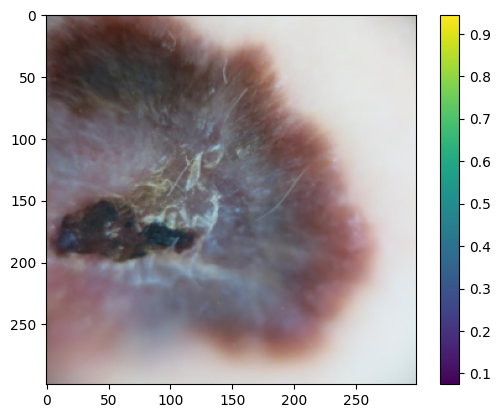

In [18]:
plt.imshow(img.permute(1, 2, 0).squeeze().numpy())
# plt.imshow(mask.squeeze().numpy())
plt.colorbar()
print(mask.unique())

In [19]:
dl_train = isic.get_loader_from_dataset(isic_train, batch_size=batch_size, shuffle=False)
dl_test = isic.get_loader_from_dataset(isic_test, batch_size=batch_size, shuffle=False)

In [20]:
def train_model_with(n_epochs, model, learning_rate, criterion, epsilon, mlx_method, k, transform):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # pre-train the model
    progress_bar = tqdm.trange(n_epochs, desc="Epoch", )
    for _ in progress_bar:
        for i, (x, u, m) in enumerate(dl_train):
            # Forward pass
            u, x, m = u.to(device), x.to(device), m.to(device)

            output = model(x)
            # For std, we will waste some time doing the bounds, but at least it is consistent across methods
            inp_grad_reg = input_gradient_interval_regularizer(
                model, x, u, "binary_cross_entropy", epsilon, 0.0, regularizer_type=mlx_method, batch_masks=m, transform=transform
            )
            if mlx_method == "std":
                assert inp_grad_reg == 0
            loss = criterion(output, u) + k * inp_grad_reg
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                progress_bar.set_postfix(loss=loss.item())

In [21]:
def test_model_acc(model):
    # evaluate the pre-trained model
    # here, param_n, param_l, param_u are the parameters of the model and l and u are the same (we did not poison)
    param_n, param_l, param_u = ct_utils.get_parameters(model)
    all_acc, i = 0, 0
    for test_batch, test_labels in dl_test:
        all_acc += agt.test_metrics.test_accuracy(param_n, param_l, param_u, test_batch, test_labels, model=model)[1]
        i += 1
    all_acc /= i
    print("--- Pre-trained model accuracy ---")
    print(f"Nominal = {all_acc:.2g}")

In [26]:
def visualize_gradient(model, batch_input, batch_labels, batch_mask, epsilon, elem_idx, transform):
    channel_to_view = 1
    batch_input, batch_labels = batch_input.to(device), batch_labels.to(device)
    grad_bounds = input_gradient_interval_regularizer(
        model, batch_input, batch_labels, "binary_cross_entropy", epsilon, 0.0, return_grads=True, regularizer_type="r4", batch_masks=batch_mask, transform=transform
    )
    dx_l, dx_u = grad_bounds[1]
    dx_n, _ = grad_bounds[0]
    print(f"input lower bound shape: {dx_l.shape}")
    print(f"input upper bound shape: {dx_u.shape}")
    print(f"input gradient shape: {dx_n.shape}")
    fig, ax = plt.subplots(3, 2, figsize=(14, 13))
    lesion = batch_input[elem_idx].permute(1, 2, 0).cpu().numpy()
    mask = batch_mask[elem_idx].cpu().numpy()
    # choose only 1 channel gradient to view, because with 3 channels, the bounds do not represent rgb values
    dx_l_view, dx_u_view, dx_n_view = dx_l[elem_idx][channel_to_view].squeez(), dx_u[elem_idx][channel_to_view].squeeze(), dx_n[elem_idx][channel_to_view].squeeze()
    ax[0][0].imshow(lesion)
    ax[0][0].set_title(f"Input at index {elem_idx}")
    im_mask = ax[0][1].imshow(mask, cmap='gray')
    ax[0][1].set_title(f"Mask at index {elem_idx}")
    fig.colorbar(im_mask, ax=ax[0][1])
    im_dx_l = ax[1][0].imshow(dx_l_view.cpu().detach().numpy())
    ax[1][0].set_title(f"Lower bound of gradient at index {elem_idx}")
    fig.colorbar(im_dx_l, ax=ax[1][0])
    im_dx_u = ax[1][1].imshow(dx_u_view.cpu().detach().numpy())
    ax[1][1].set_title(f"Upper bound of gradient at index {elem_idx}")
    fig.colorbar(im_dx_u, ax=ax[1][1])
    im_dx_n = ax[2][0].imshow(dx_n_view.cpu().detach().numpy())
    ax[2][0].set_title(f"Gradient at index {elem_idx}")
    fig.colorbar(im_dx_n, ax=ax[2][0])

In [27]:
# define model, dataset and optimizer
num_epochs = 1
lr = 0.01
restarts = 3
epsilon = 0.01
# k is a coefficient for the regularization term
k = 0.2
model = DeepMindAugmented(3, 1)
criterion = torch.nn.BCELoss()
model = model.to(device)
print(model)

DeepMindAugmented(
  (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(3, 3))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=76832, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=1, bias=True)
  (8): Sigmoid()
)


21


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch input shape: torch.Size([50, 3, 299, 299]), batch mask shape: torch.Size([50, 299, 299])
['param 0 shape: torch.Size([16, 3, 4, 4, 1])', 'param 1 shape: torch.Size([16, 1])', 'param 2 shape: torch.Size([32, 16, 4, 4, 1])', 'param 3 shape: torch.Size([32, 1])', 'param 4 shape: torch.Size([100, 76832])', 'param 5 shape: torch.Size([100, 1])', 'param 6 shape: torch.Size([1, 100])', 'param 7 shape: torch.Size([1, 1])']
input lower bound shape: torch.Size([50, 3, 298, 298])
input upper bound shape: torch.Size([50, 3, 298, 298])
input gradient shape: torch.Size([50, 3, 298, 298])


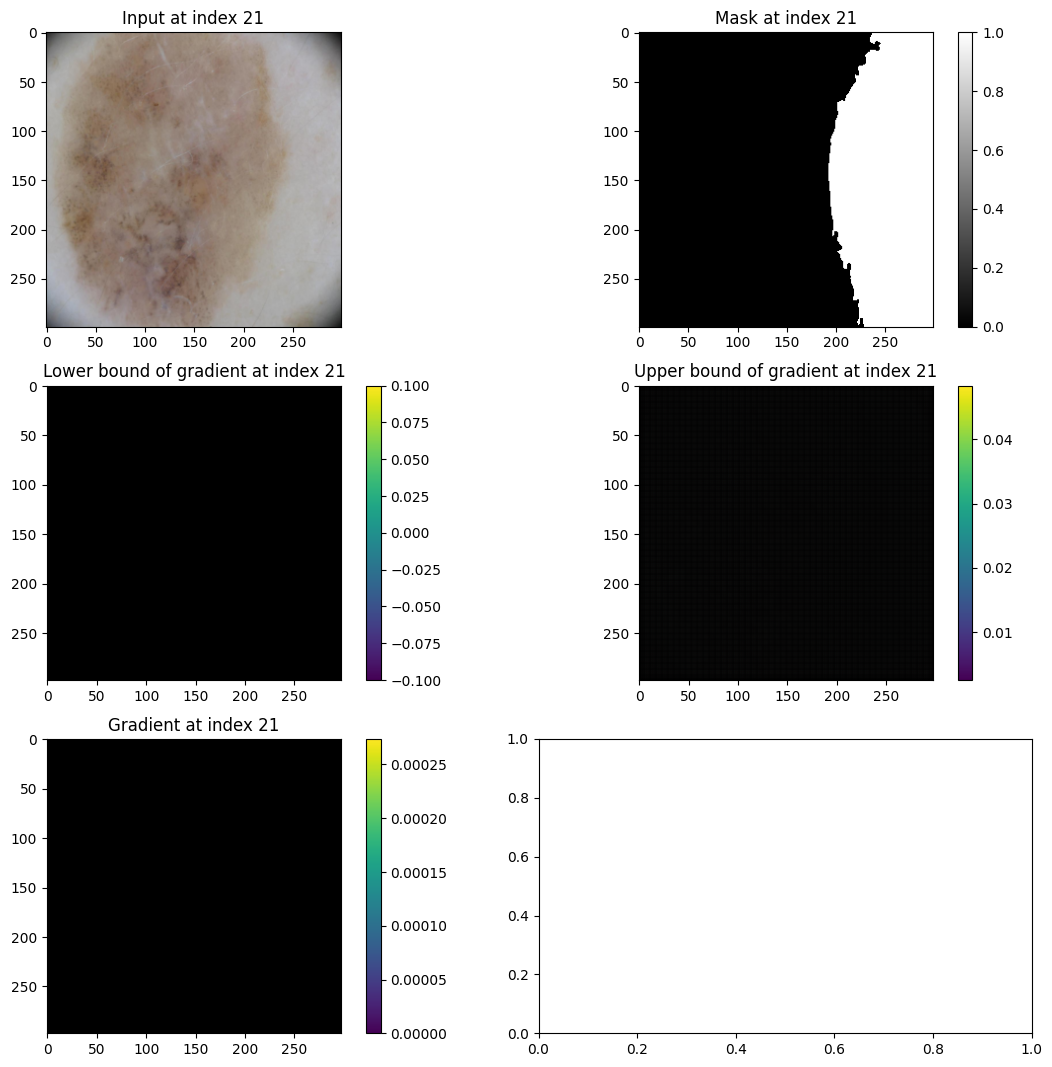

In [28]:
idx_to_visualize = torch.randint(0, batch_size, (1,)).item()
print(idx_to_visualize)
init_batch_train_with_masks = next(iter(dl_train))
print(f"Batch input shape: {init_batch_train_with_masks[0].shape}, batch mask shape: {init_batch_train_with_masks[2].shape}")
visualize_gradient(model, *init_batch_train_with_masks, epsilon, idx_to_visualize, ct_utils.propagate_conv_layers)

## Experiments 

In [43]:
DELTA_INPUT_ROBUSTNESS_PARAM = 0.1

In [57]:
def test_delta_input_robustness(model):
    # The model needs to be delta input robust only in the irrelevant features
    num_robust = 0
    for test_batch, test_labels, test_masks in dl_masks_test:
        test_batch, test_labels, test_masks = test_batch.to(device), test_labels.to(device), test_masks.to(device)
        test_batch = test_batch.flatten(start_dim=1)
        test_masks = test_masks.flatten(start_dim=1)
        # The MLX method does not really matter, as we return the grads
        grad_bounds = input_gradient_interval_regularizer(model, test_batch, test_labels, "cross_entropy", epsilon, 0.0, return_grads=True, batch_masks=test_masks)
        d_l, d_u = grad_bounds[1]
        d_l, d_u = d_l.flatten(start_dim=1), d_u.flatten(start_dim=1)
        d_l, d_u = d_l * test_masks, d_u * test_masks
        abs_diff = torch.abs(d_l - d_u)
        # [batch_size, input_dim]
        robust_grad_inputs = torch.where(abs_diff <= DELTA_INPUT_ROBUSTNESS_PARAM, 1, 0).bool()
        # [batch_size]
        is_robust_grad = robust_grad_inputs.all(dim=-1)
        num_robust += is_robust_grad.sum().item()
    num_robust /= len(dl_masks_test.dataset)
    print("--- Pre-trained model delta input robustness ---")
    print(f"Delta Input Robustness = {num_robust:.2g}")


### Standard Training

========== Training model with method std restart 0 ==========


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 100%|██████████| 10/10 [00:17<00:00,  1.72s/it, loss=1.47]


--- Pre-trained model accuracy ---
Nominal = 0.68
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0.9
========== Training model with method std restart 1 ==========


Epoch: 100%|██████████| 10/10 [00:17<00:00,  1.71s/it, loss=1.47]


--- Pre-trained model accuracy ---
Nominal = 0.69
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0.9
========== Training model with method std restart 2 ==========


Epoch: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it, loss=1.46]


--- Pre-trained model accuracy ---
Nominal = 0.7
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0.9


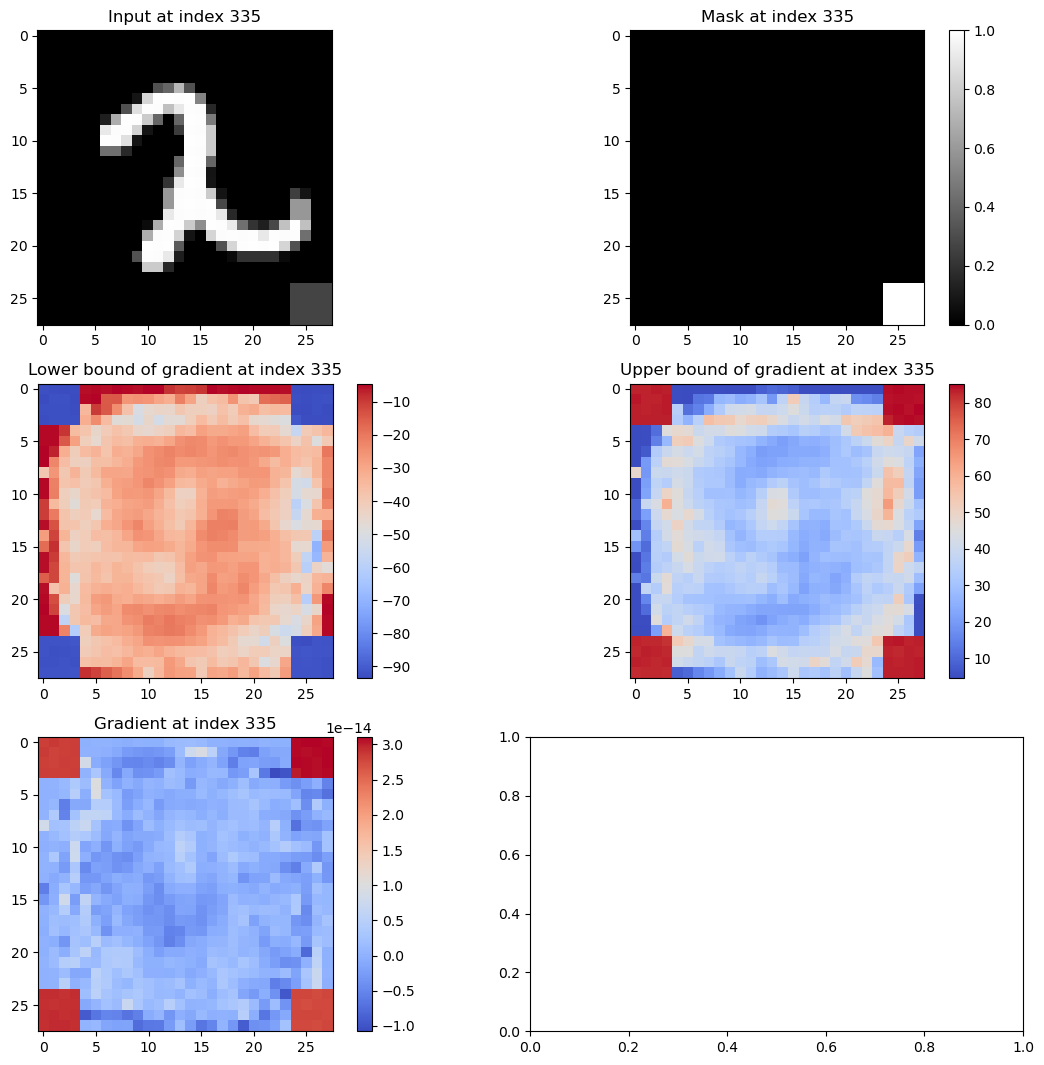

In [59]:
mlx_method = "std"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FullyConnected(*ARCH)
    curr_model.append(torch.nn.Softmax(dim=1))
    curr_model = curr_model.to(device)

    print(f"========== Training model with method {mlx_method} restart {i} ==========")
    train_model_with(num_epochs, curr_model, lr, criterion, epsilon, mlx_method, k)
    test_model_acc(curr_model)
    test_delta_input_robustness(curr_model)
    if i == restarts - 1:
        visualize_gradient(curr_model, *init_batch_train_with_masks, epsilon, idx_to_visualize)

### RRR Training

========== Training model with method r3, restart 0 ==========


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 100%|██████████| 10/10 [00:25<00:00,  2.53s/it, loss=1.48]


--- Pre-trained model accuracy ---
Nominal = 0.68
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0.9
========== Training model with method r3, restart 1 ==========


Epoch: 100%|██████████| 10/10 [00:25<00:00,  2.55s/it, loss=1.47]


--- Pre-trained model accuracy ---
Nominal = 0.69
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0.9
========== Training model with method r3, restart 2 ==========


Epoch: 100%|██████████| 10/10 [00:25<00:00,  2.51s/it, loss=1.48]


--- Pre-trained model accuracy ---
Nominal = 0.7
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0.9


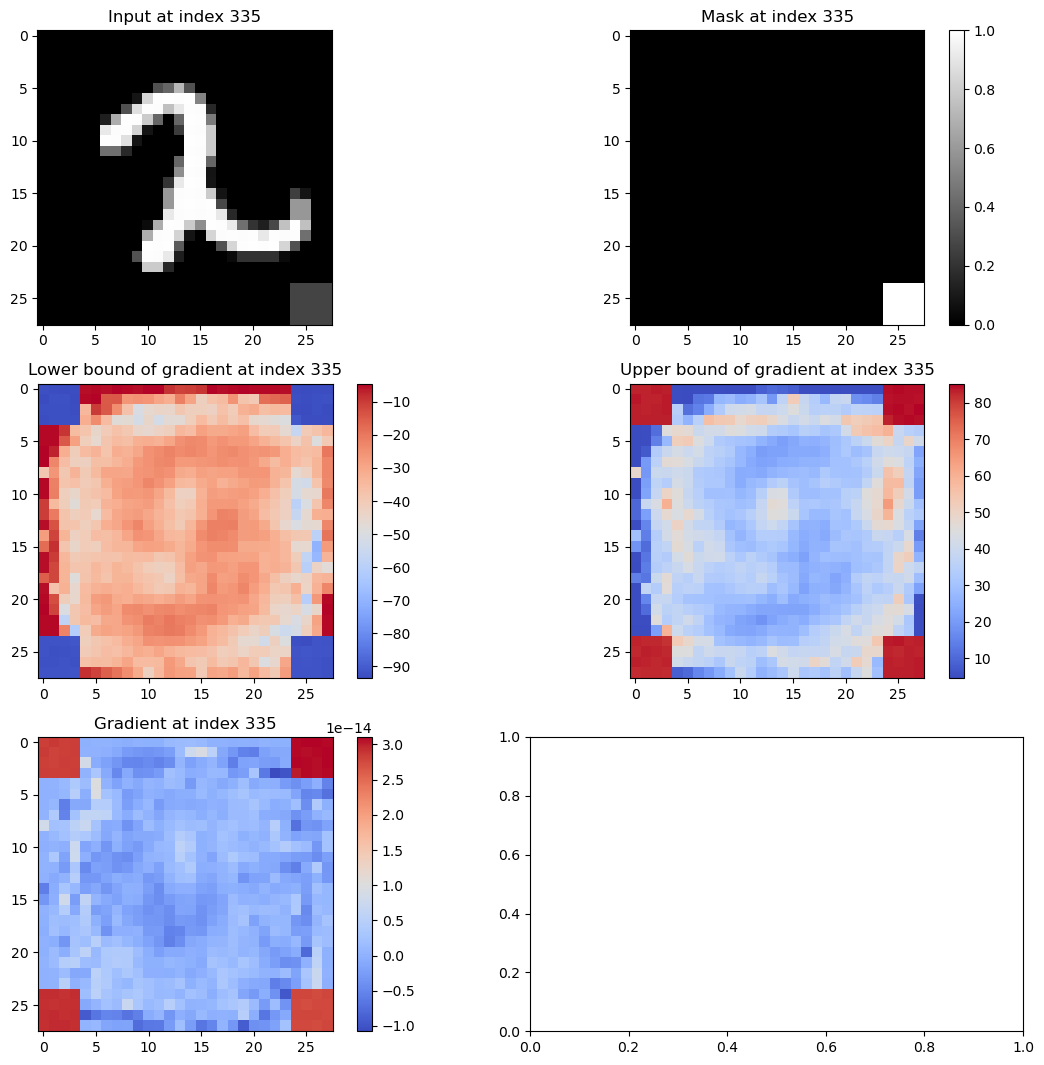

In [71]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
rrr_method = "r3"
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FullyConnected(*ARCH)
    curr_model.append(torch.nn.Softmax(dim=1))
    curr_model = curr_model.to(device)

    print(f"========== Training model with method {rrr_method}, restart {i} ==========")
    train_model_with(num_epochs, curr_model, lr, criterion, epsilon, rrr_method, 1e-2)
    test_model_acc(curr_model)
    test_delta_input_robustness(curr_model)
    if i == restarts - 1:
        visualize_gradient(curr_model, *init_batch_train_with_masks, epsilon, idx_to_visualize)

========== Training model with method R4, restart 0 ==========


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 100%|██████████| 10/10 [00:20<00:00,  2.06s/it, loss=1.48]


--- Pre-trained model accuracy ---
Nominal = 0.97
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0.9
========== Training model with method R4, restart 1 ==========


Epoch: 100%|██████████| 10/10 [00:20<00:00,  2.06s/it, loss=1.48]


--- Pre-trained model accuracy ---
Nominal = 0.98
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0.9
========== Training model with method R4, restart 2 ==========


Epoch: 100%|██████████| 10/10 [00:20<00:00,  2.07s/it, loss=1.48]


--- Pre-trained model accuracy ---
Nominal = 0.98
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0.9


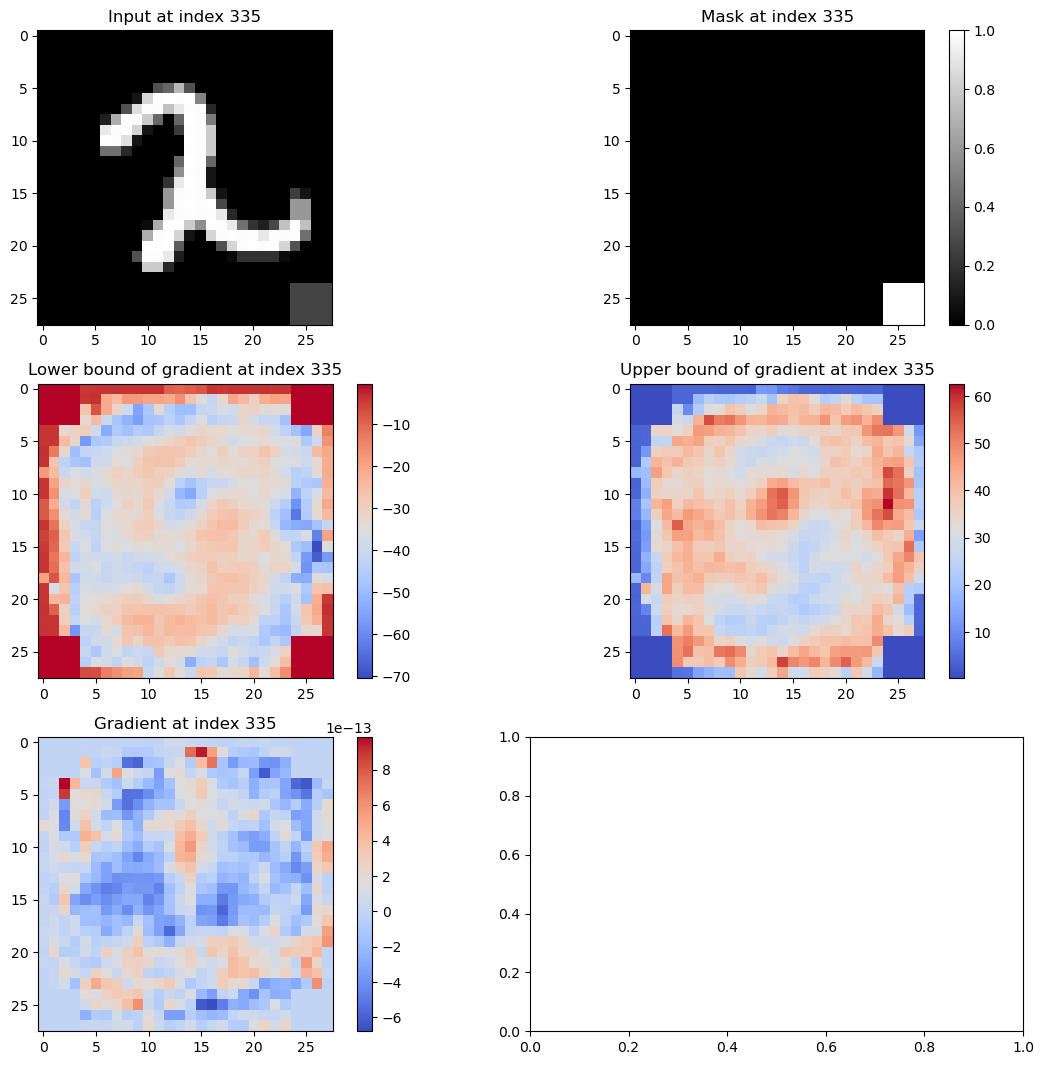

In [62]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
r4_method = "r4"
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FullyConnected(*ARCH)
    curr_model.append(torch.nn.Softmax(dim=1))
    curr_model = curr_model.to(device)

    print(f"========== Training model with method R4, restart {i} ==========")
    train_model_with(num_epochs, curr_model, lr, criterion, epsilon, r4_method, k)
    test_model_acc(curr_model)
    test_delta_input_robustness(curr_model)
    if i == restarts - 1:
        visualize_gradient(curr_model, *init_batch_train_with_masks, epsilon, idx_to_visualize)